In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
# df = pd.read_csv('/kaggle/input/ccdata/CC GENERAL.csv')
df = pd.read_csv('CC_GENERAL.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# PREPROCESSING

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

# TRYING TO UNDERSTAND THIS DATA
- **CUSTID** : [Categorical] ID of the customer which freaks out the clustering, hence we're gonna drop this.

- **BALANCE** : How rich is this guy?

- **BALANCEFREQUENCY** : How often this guy tops up their account $$\$?

- **PURCHASES** : How much money this person spent so far?

- **ONEOFFPURCHASES** : The costliest bill so far.

- **INSTALLMENTSPURCHASES** : The bills this person hesitated to make in one go.

- **CASHADVANCE** : Cash in advance given by this person

- **PURCHASESFREQUENCY** : How Mr.Beast is this guy?

- **ONEOFFPURCHASESFREQUENCY** : How un-hesitating Mr.Beast is this guy?

- **PURCHASESINSTALLMENTSFREQUENCY** : How hesitating Mr.Beast is this guy?

- **CASHADVANCEFREQUENCY** : How frequently the cash in advance being paid

- **CASHADVANCETRX** : Number of Transactions made with "Cash in Advanced"

- **PURCHASESTRX** : How busy is this guy purchasing things?

- **CREDITLIMIT** : The limit of this guy's paradise

- **PAYMENTS** : Amount of Payment done by user

- **MINIMUM_PAYMENTS** : Minimum amount of payments made by user

- **PRCFULLPAYMENT** : Percent of full payment paid by user

- **TENURE** : Tenure of credit card service for user

(Mr. Beast is a famous YouTuber who seems to be rich and spending lots of money for the sole purpose of entertainment.)

In [6]:
X = df.drop('CUST_ID', axis=1)

## HANDLING NA
Now, let's check if someone hesitated to provide the data

In [7]:
X.isna().sum().sort_values(ascending=False).head()

MINIMUM_PAYMENTS          313
CREDIT_LIMIT                1
BALANCE                     0
CASH_ADVANCE_FREQUENCY      0
PRC_FULL_PAYMENT            0
dtype: int64

Yeah, these guys never know that we're gonna use their neighbors' to profile them. Sad for them. Let's enquire 3 of their neighbors and ask about them. *Knock Knock, FBI!* 

In [8]:
from sklearn.impute import KNNImputer

knn_imp = KNNImputer(n_neighbors=3)
X = pd.DataFrame(knn_imp.fit_transform(X), columns=X.columns)

In [9]:
# Just making sure that..., you already know... [well, making sure that there are no null values]

X.isna().sum().sum()

0

In [10]:
# Ah!!! The eye feast libraries...!

import matplotlib.pyplot as plt
import seaborn as sns

## HANDLING SKEW
Let's check if these guys tend towards something like *anything..!*

<AxesSubplot:>

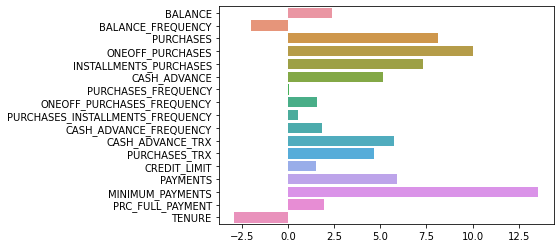

In [11]:
X_sk_vals = X.skew()
sns.barplot(x=X_sk_vals.values, y=X_sk_vals.index)

Well, Sure they are. Let's teach them some manners. Using [log transformation](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) to cure the skewness.

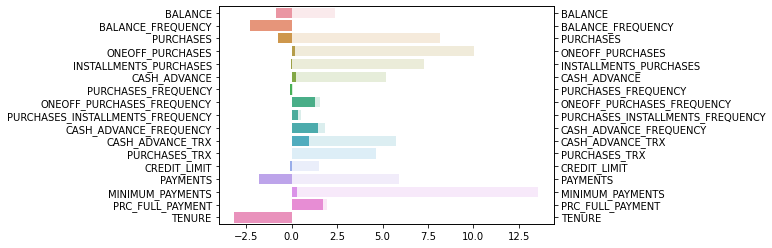

In [12]:
X_unsk = X.apply(lambda x: np.log(1+x)) # X_unsk --> Unskewed X
X_unsk_vals = X_unsk.skew()             # X_unsk_vals --> Skew coefficients of X_unsk

ax = sns.barplot(x=X_sk_vals.values, y=X_sk_vals.index, alpha=0.2)
ax2 = ax.twinx()
sns.barplot(x=X_unsk_vals.values, y=X_unsk_vals.index, ax=ax2)
plt.show()

Well, Now that they're in good shape, let's see how this affected the guys' profiles.

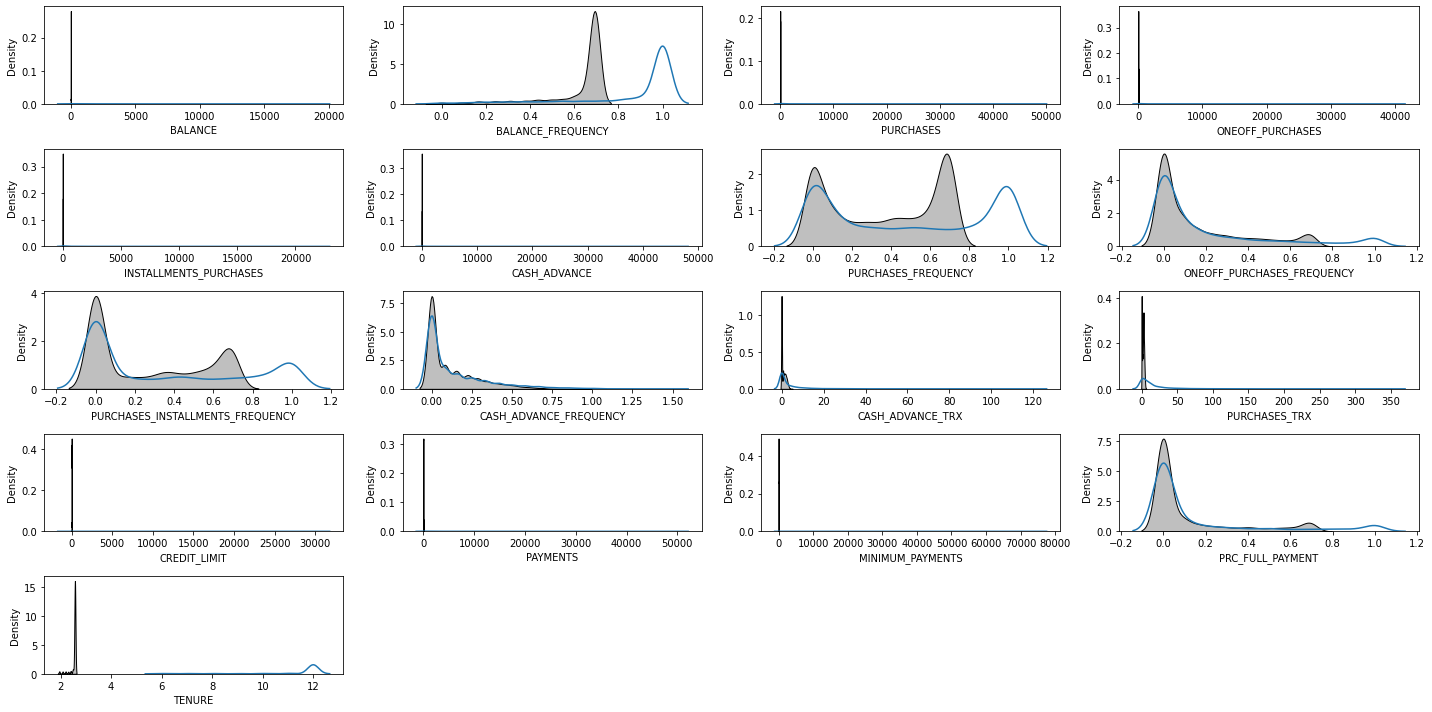

In [13]:
#  KDE [Kernel Desnity Estimate] provides "Probability Density Curve"

fig = plt.figure(figsize=(20, 10))
for idx, col in enumerate(X.columns, 1):
    ax = fig.add_subplot(5, 4, idx)
    sns.kdeplot(X[col], bw_adjust=1, ax=ax)
    sns.kdeplot(X_unsk[col], bw_adjust=1, ax=ax, fill=True, color='black')

plt.tight_layout()

# Light plot is original data
# Dark plot is transformed data

Reducing the skewness is all about achieveing symmetry.

## HANDLING OUTLIERS
Now, let's try to look at some crazy people from the given data. Technically, *Outliers*

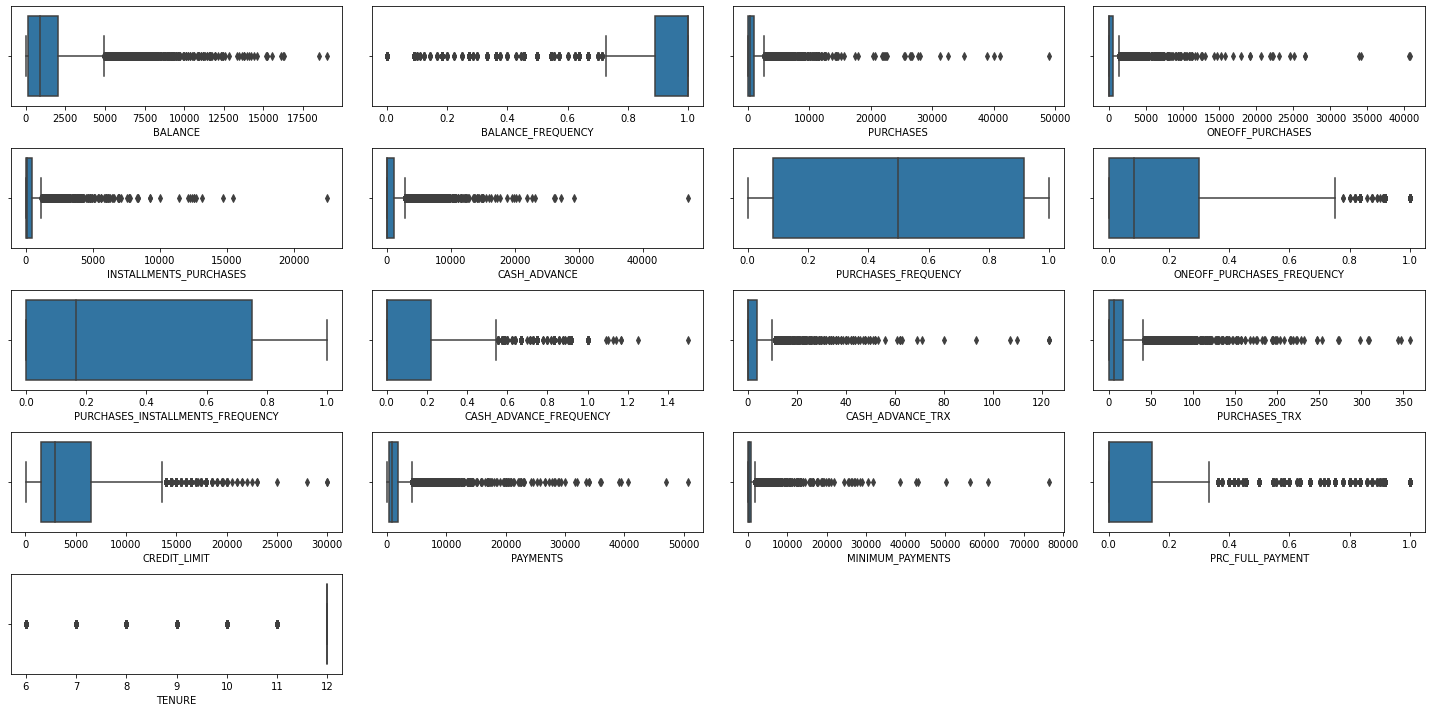

In [14]:
fig = plt.figure(figsize=(20, 10))
for idx, col in enumerate(X.columns, 1):
    ax = fig.add_subplot(5, 4, idx)
    sns.boxplot(x=X[col], ax=ax)

plt.tight_layout()

Phew, This dataset seems to be the dataset of outliers. There're ton of outliers. We can't just remove them. Nothing much we can do now except moving on with the weight of outliers...

Now, studying how well these guys' actions depend on each other

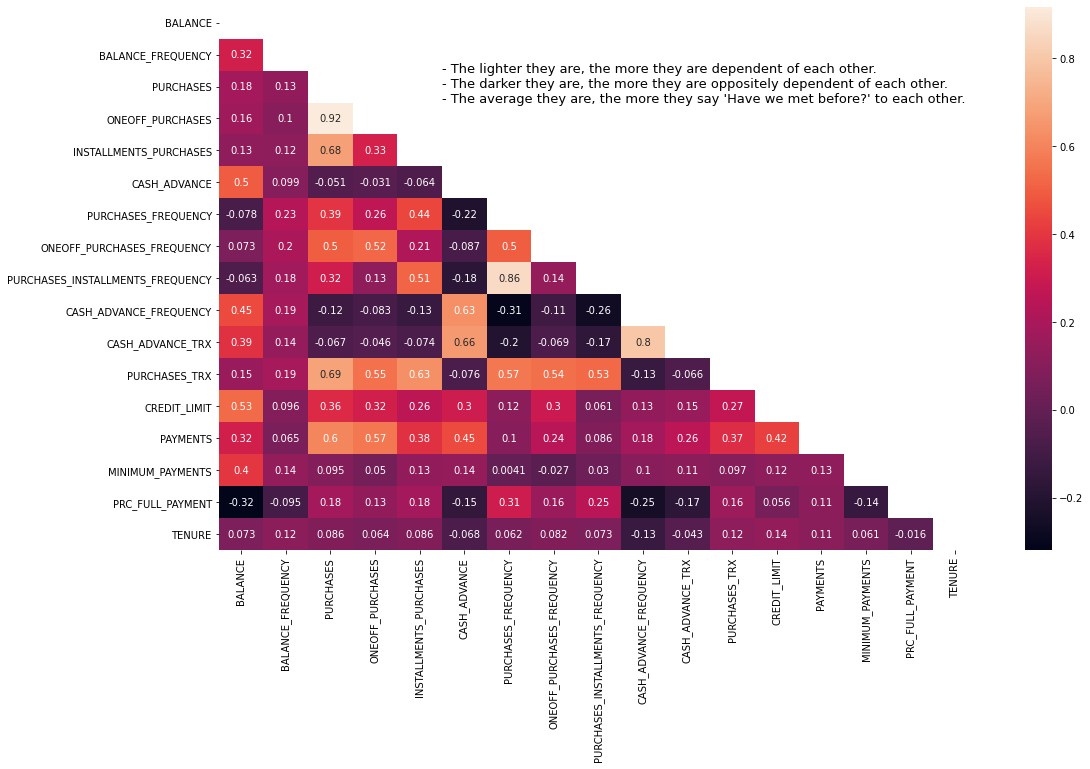

In [16]:
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(17, 10))
sns.heatmap(corr, mask=mask, annot=True)
text = """- The lighter they are, the more they are dependent of each other.
- The darker they are, the more they are oppositely dependent of each other.
- The average they are, the more they say 'Have we met before?' to each other."""
plt.text(5, 3, text, size=13)
plt.show()

> "Ah, Sounds well!, But what's the point of all this? Few things are dependent of other, and other few are independent of some others."

Although you missed, there's a point to all this.
You see, as few varibles depend on each other, they can help us (and our model) to make assumptions about the data that we need to form clusters. If you are crazy enough to imagine multi-dimensional space and each of these guys (customers) as a points in higher dimensional space, then these correlations can tell us how they're oriented with each other [orientation in terms of axes].

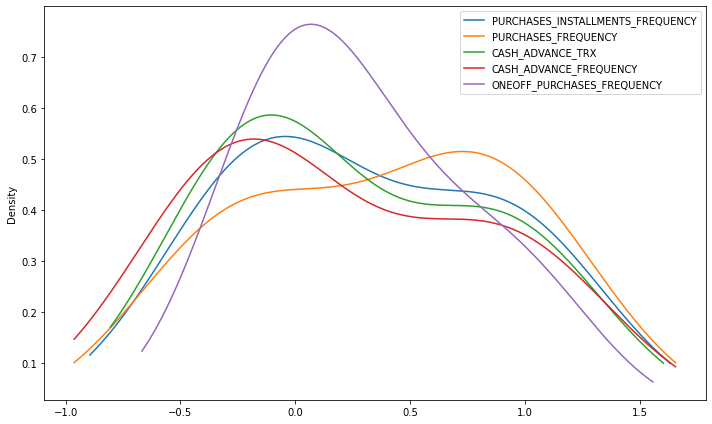

In [17]:
check_corr_for = ['PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_TRX', 'CASH_ADVANCE_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY']
X[check_corr_for].corr().plot.kde(figsize=(10, 6))
plt.tight_layout()

Alright, [AIright](Nothing,_I_just_wanted_to_show_you_that_I_used_"I"_insted_of_"l"), Alright!

Now, let's work on clustering these guys based on their behaviour.

## STANDARDIZATION
I guess we need to standardize the data, before diving any deeper.

> Stan-dar-dai-zing? What the heck is that? 

Well, Glad you asked. Let's say I've a friend, and she has these crazy super powers (let's call her 'meta-human'). So, one day while we're casually hanging out, and suddenly a group of 10 aliens appeared out of no where and started attacking. We did some freaking out and started fighting them. However, my friend as she has super powers, took down 7 aliens with her mighty powers. and I as a normal person, took down 3 aliens. Now the question is, who worked hard?
This is where **stan-dar-dai-zing** comes into play.

Let's say, on "average", humans has enough capacity to take down **5 aliens ( ± 1 alien)**.

And, on "average", meta-humans has capability of taking down **10 aliens (± 2 aliens)**.

So, my Z-score (standardised value) is `(my_value - average_value) / std. deviation` => `(3 - 5) / 1` => `-2`

my friend's Z-score is => `(7 - 10) / 2` => `-3/2` => `-1.5`

Now that, we've Z-scores. we can compare these scores to get the result. (Feeling bad to say that my friend worked harder than me.)

Now, back to business.

In [18]:
from sklearn.preprocessing import StandardScaler

Xs = StandardScaler().fit_transform(X) # Xs -> X standardized

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# KMEANS CLUSTERING 
Now that we have our data neat and ready, we shall start builing our model with "Kay-Meens" algorithm. (where it clusters the data into 'Kay' clusters, and each cluster center is it's 'Meen'). [I just wanted to make sure that you don't pronounce it as 'Kh-Mins']

Skip the following cell, if you're um... [not sure]

In [17]:
clusters_you_need = 5
the_number_that_follows_you = 7
favourite_number = the_number_that_follows_you

assert(favourite_number not in [-np.inf, np.inf]), "You're the one I'm looking for!. because your number is {}".format(favourite_number)
assert(isinstance(favourite_number, int)) , "If I knew about you, I would've mentioned it as integer. because your number is {}".format(favourite_number)
assert(favourite_number >= 0), "You've no place in this dimension. because your number is {}".format(favourite_number)

random_number = favourite_number
random_state = random_number
kh_mins_dummy = KMeans(n_clusters=clusters_you_need, random_state=random_state)
# random_state is optional, which means, the above stupid procedure is all optional.
cluster_results = kh_mins_dummy.fit_predict(Xs)

That is how I'd do if I get drunk. Here, I fixed my cluster count myself in prior without any insights. which is sh_t.

Now that we discovered what to avoid, let's get working to find how many clusters we need.

In general, there's this thing called `silhouette_score`, which scores the clusters. The more the score, the good the clusters.

And there's also another metric for Kay-Meens, which is `Within Cluster Summation of Squares [WCSS]`. It tells about the squared distances between clusters. People often call it as "Elbow method", the process of identifying the elbow in the WCSS plot, which brings us good results.

In [20]:
cluster_range = range(2, 15)

km_WCSS_scores = []
km_sil_scores = []  # sil is nick name for silhouette

for kay in cluster_range:
    kh_mins = KMeans(n_clusters=kay)
    y_tmp = kh_mins.fit_predict(Xs)  # y_tmp are the cluster results based on Xs (Stan-dar-dised)
    km_WCSS_scores.append(kh_mins.inertia_)  # that's how you get the score
    km_sil_scores.append(silhouette_score(Xs, y_tmp))

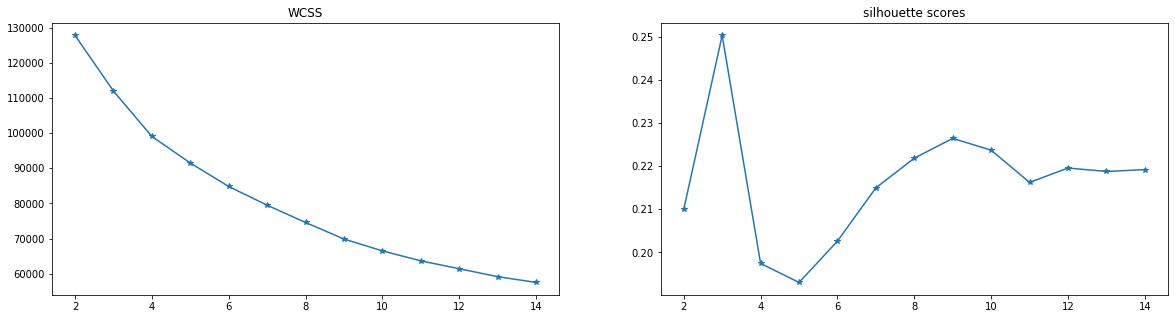

In [21]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title('WCSS')
plt.plot(cluster_range, km_WCSS_scores, marker='*')


plt.subplot(1, 2, 2)
plt.title('silhouette scores')
plt.plot(cluster_range, km_sil_scores, marker='*')

Why do I feel that 8 is the right number. Well, let's continue with 8.

In [22]:
kh_mins = KMeans(n_clusters=8).fit(Xs)
kh_mins_sil_score = silhouette_score(Xs, kh_mins.labels_)     
# Well, if I'm right, you're thinking about something. If so, yes, they're the same.
kh_mins_sil_score

0.21912894758904208

Let's try some more algorithms, shall we?

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering

# DBSCAN CLUSTERING 
Now, with DEE-BEE-SKAN [Density Based Spatial Clustering of Applications with Noise]

This thing works like a virus or a parasite. It accumulates the neighboring points into it's clusters [with a constraint]. We have to have two parameters. 

- maximum distance - if a distance to a point is less than this distance, it accumulates. Like 6 feet distance for COVID-19.
- minimum samples - inorder to form a cluster, it needs to have these many points in range.

Well, one way to find maximum distance (epsilon) (eps) is with NearestNeighbors.

In [24]:
# we need the distance of nearest neighbor to every point, so that we can get an idea about
# how close neighbors are located to each other.
# we're considering 2 neighbors because every point is a 1st neighbor to itself.
knn = NearestNeighbors(n_neighbors=2).fit(Xs)
distances, indicies = knn.kneighbors(Xs)

In [25]:
distances[:7]
# Observe that 1st column is all zeroes, because it's the distance to itself.

array([[0.        , 0.40260669],
       [0.        , 1.25793034],
       [0.        , 0.40459424],
       [0.        , 1.04400268],
       [0.        , 0.10444936],
       [0.        , 0.7362152 ],
       [0.        , 2.31026033]])

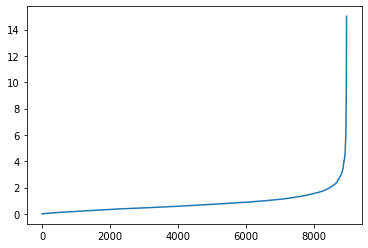

In [26]:
neighbor_distances = distances[:, 1]
sorted_neighbor_distances = sorted(neighbor_distances)
plt.plot(sorted_neighbor_distances)

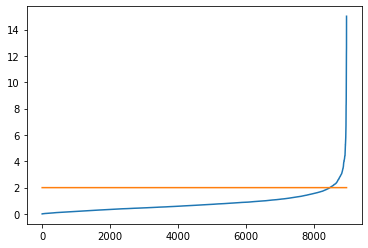

In [27]:
# Well, most of the neighbors are within distance "2"
plt.plot(sorted_neighbor_distances)
plt.plot(range(len(sorted_neighbor_distances)), [2]*len(sorted_neighbor_distances))

In [28]:
db_sil_scores = []

for ep in np.arange(0.2, 3, 0.2):
    for min_samps in range(2, 10, 2):
        y_tmp = DBSCAN(eps=ep, min_samples=min_samps).fit_predict(Xs)
        cluster_count = len(np.unique(y_tmp))
        db_sil_scores.append([ep, min_samps, cluster_count, silhouette_score(Xs, y_tmp)])

db_df = pd.DataFrame(db_sil_scores, columns=['eps', 'min_samples', 'cluster_count', 'sil_score']).sort_values('sil_score', ascending=False)

In [27]:
db_df.head()

,eps,min_samples,cluster_count,sil_score
54,2.8,6,2,0.598731
55,2.8,8,2,0.594549
50,2.6,6,2,0.573389
51,2.6,8,2,0.569511
46,2.4,6,2,0.549966


Well, I guess we can't continue with DBSCAN, because if you observe the peak score results in only 2 clusters, where 1 is a cluster and another is a outlier. This might be helpful if your goal is to identify outliers.

# HIERARCHIAL CLUSTERING 
Now, with hier-arch-ial clustering, in which every point is it's own individual cluster, then they start merging into bigger cluster until you stop them.

To stop them, you need a score, and that score has some styles. for example, "linkage", it has few styles "single", "average", "complete", "centroid", etc.....

- `a(1234) b(5678)` - SINGLE LINKAGE - distance between `4` and `5`
- `a(1234) b(5678)` - COMPLETE LINKAGE - distance between `1` and `8`
- `a(1234) b(5678)` - AVERAGE LINKAGE - distance of `all_possible_pairs_between_clusters_distances.mean()`
- `a(1234) b(5678)` - CENTROID LINKAGE - distance between `a.centroid` and `b.centroid`

there's also this cool dendRogram visualisation of clsutering for hier-arch-ial.

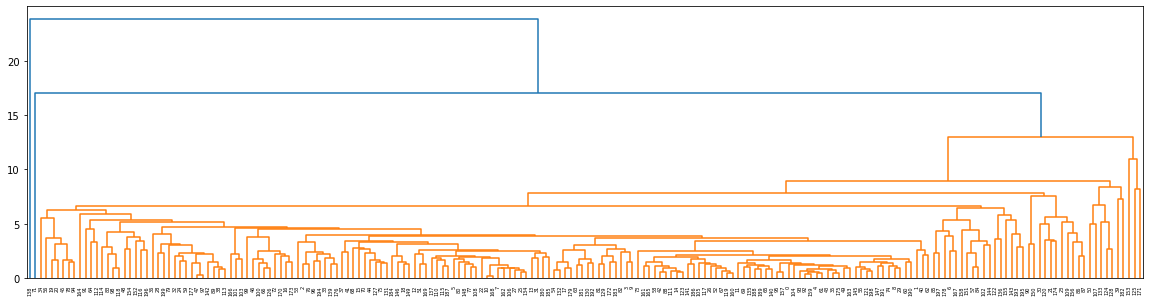

In [28]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(20, 5))
dendro = dendrogram(linkage(Xs[:200], 'average'))
# Limited to 200 rows respecting the Kaggle servers.

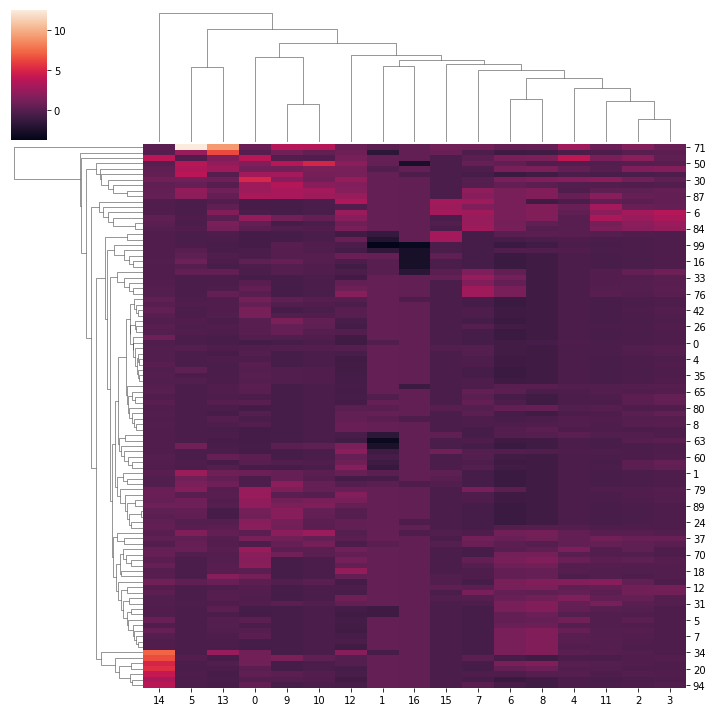

In [29]:
# Another cool visualisation which might bring back the memories of "we might be living in a simulation."
sns.clustermap(Xs[:100], linewidths=0.002)

Now, back to analyzing sil-hou-ette scores.

In [30]:
aggl_sil_scores = []

cluster_range = range(2, 20, 2)
for i in cluster_range:
    for link_type in ['average', 'single', 'ward']:
        y_tmp = AgglomerativeClustering(n_clusters=i, linkage=link_type).fit_predict(Xs)
        aggl_sil_scores.append([i, link_type, silhouette_score(Xs, y_tmp)])

aggl_df = pd.DataFrame(aggl_sil_scores, columns=['cluster_count', 'linkage', 'sil_score']).sort_values('sil_score', ascending=False)

In [31]:
aggl_df.head()

,cluster_count,linkage,sil_score
0,2,average,0.849634
1,2,single,0.840750
3,4,average,0.838193
4,4,single,0.812045
7,6,single,0.770240


In [32]:
#  Let's pick the top one with 4 clusters. 2 clusters would be pretty bland.
agglo = AgglomerativeClustering(n_clusters=4, linkage='average').fit(Xs)
agglo_sil_score = silhouette_score(Xs, agglo.labels_)
agglo_sil_score

0.8381926129712927

- KMeans - 0.22
- DBSCAN - Ineligible
- Agglom - 0.83 [✓]

In [33]:
X['cluster'] = agglo.labels_
X['cluster'].value_counts()

0    8943
1       5
2       1
3       1
Name: cluster, dtype: int64

Wh-What's that?

That's not good, most of the points lie in the single cluster. Well, let's pick another model.

In [34]:
agglo = AgglomerativeClustering(n_clusters=6, linkage='single').fit(Xs)
agglo_sil_score = silhouette_score(Xs, agglo.labels_)
agglo_sil_score

0.7702397360152874

In [35]:
X['cluster'] = agglo.labels_
X['cluster'].value_counts()

0    8945
1       1
2       1
3       1
4       1
5       1
Name: cluster, dtype: int64

Well, let's go with the KMeans instead.

In [36]:
X['cluster'] = kh_mins.labels_
X['cluster'].value_counts()

7    2823
1    2031
3    1264
0    1186
4     880
6     629
2      80
5      57
Name: cluster, dtype: int64

# VISUALISATION
Now, to the exciting part.

## NOI⊥Ͻ∩ᗡƎᴚ ʎ⊥I˥∀NOISNƎWIᗡ - PCA
and the visualisation of clusters 

In [37]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [38]:
Xn = normalize(Xs)  
# Normalizing Xs because..., wait for few cells.

PCA [Principal Component Analyziz] is used to reduce dimesnions of a dataset / dataframe / matrix / vectors / you / me / that bird you saw today morning, without losing much information. The information lies in the variance. The more the variance you aquire, the less the data you lose. It based on SVD [Singular Value Decomposition] which is based on a principle of factorizing any matrix into three different matrices with unit vectors and eigen values.

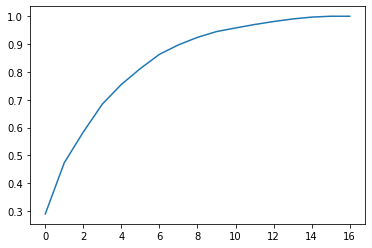

In [39]:
pca_test = PCA().fit(Xn)
plt.plot(pca_test.explained_variance_ratio_.cumsum())
# the following plot tells us the variance we manage to get aganist the number of dimensions.

In [40]:
# Since, we just need PCA to visualize data, we can simply reduce dimensions to 2 or 3. 
# Remember, you can also reduce the Xs to lower dimensions and then apply clustering models.
# Just make sure, you're not losing much variance.

pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

Xn_2d = pca_2d.fit_transform(Xn)
Xn_3d = pca_3d.fit_transform(Xn)

normalize_Xs_because = PCA(n_components=2).fit_transform(Xs)

In [41]:
Xn_2d.shape, Xn_3d.shape, normalize_Xs_because.shape

((8950, 2), (8950, 3), (8950, 2))

<AxesSubplot:>

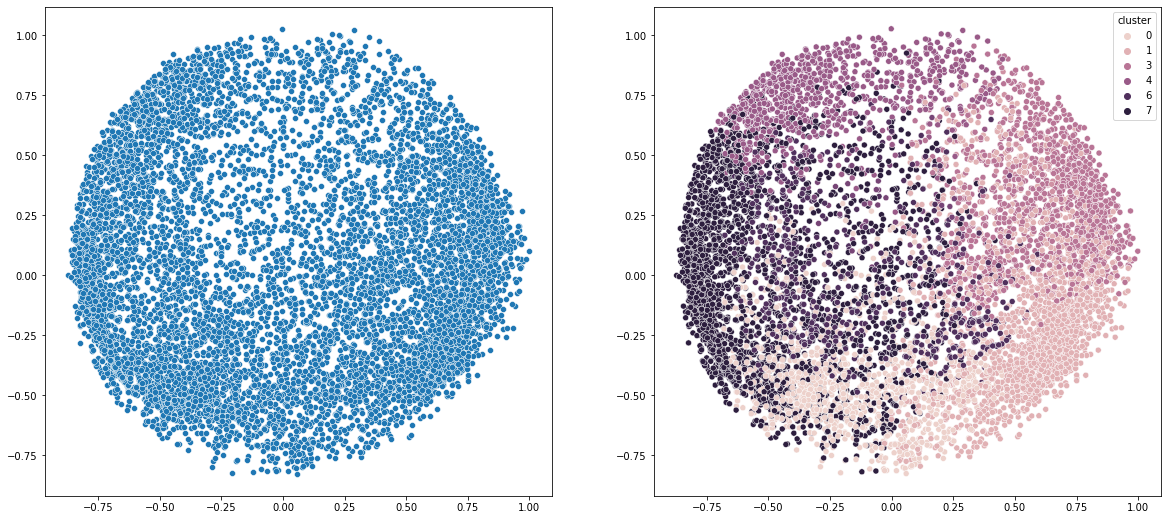

In [42]:
plt.figure(figsize=(20, 9))
x_, y_ = Xn_2d.T

plt.subplot(1, 2, 1)
sns.scatterplot(x=x_, y=y_)

plt.subplot(1, 2, 2)
sns.scatterplot(x=x_, y=y_, hue=X['cluster'])

In [43]:
import plotly.express as px

x_, y_, z_ = Xn_3d.T
fig = px.scatter_3d(x=x_, y=y_, z=z_, color=X['cluster'])
fig.show()

Now, to see why we need to normalize before PCA

<AxesSubplot:>

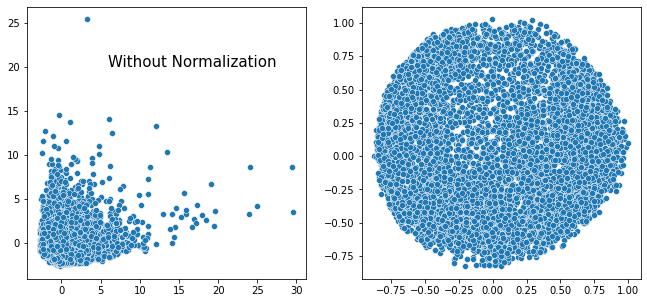

In [44]:
plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.text(6, 20, 'Without Normalization', size=15)
x_, y_ = normalize_Xs_because.T
sns.scatterplot(x=x_, y=y_)

plt.subplot(1, 2, 2)
x_, y_ = Xn_2d.T
sns.scatterplot(x=x_, y=y_)

Anyways, it's all just for visualisation

## t-SNE  
Now, let's try t-SNE [t-Distributed Stochastic Neighbor Embedding], which is a manifold learning algorithm. Simply like Doctor Strange - It has ability to bend spaces. 

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
Xn_tsne_2d = tsne.fit_transform(Xn)

<AxesSubplot:>

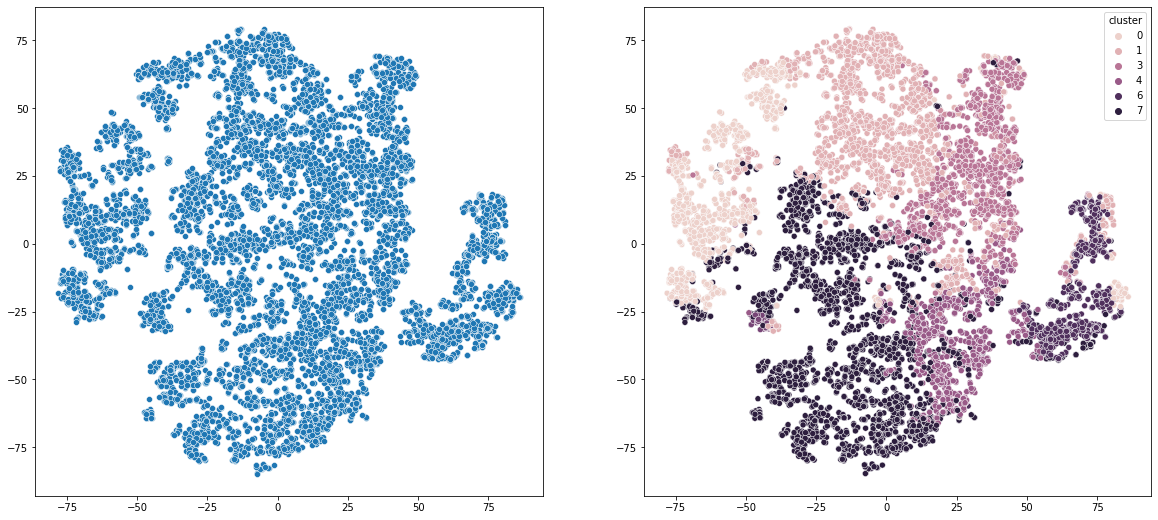

In [46]:
plt.figure(figsize=(20, 9))
x_, y_ = Xn_tsne_2d.T

plt.subplot(1, 2, 1)
sns.scatterplot(x=x_, y=y_)

plt.subplot(1, 2, 2)
sns.scatterplot(x=x_, y=y_, hue=X['cluster'])

Alright. That's it. 

Let's look at the how features are classified with clusters.

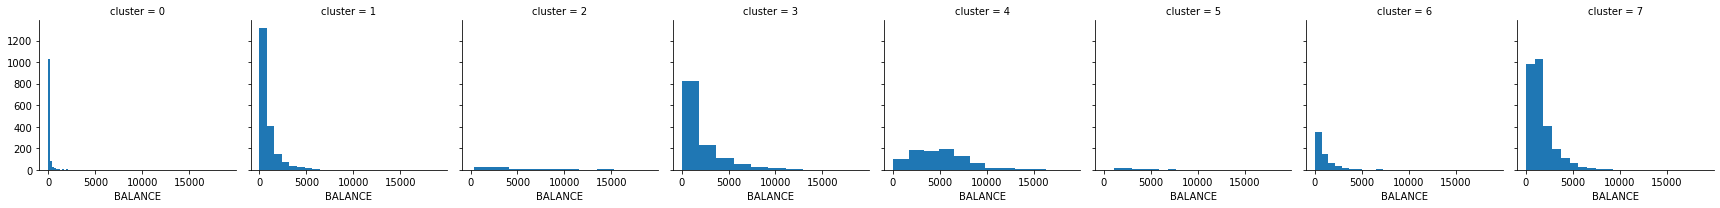

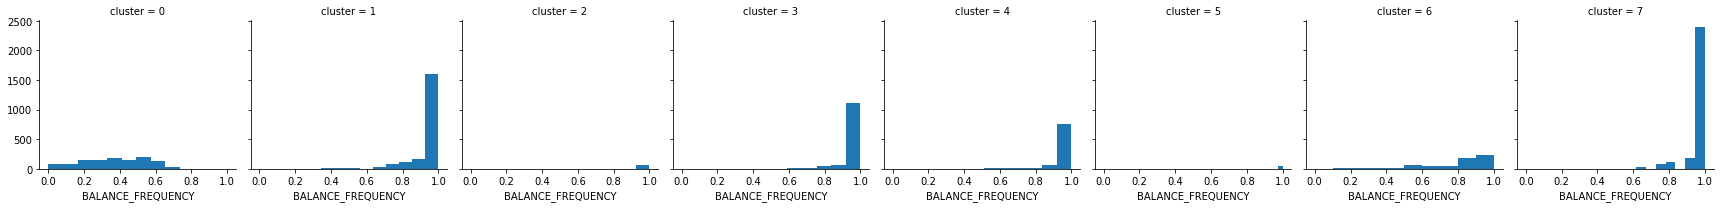

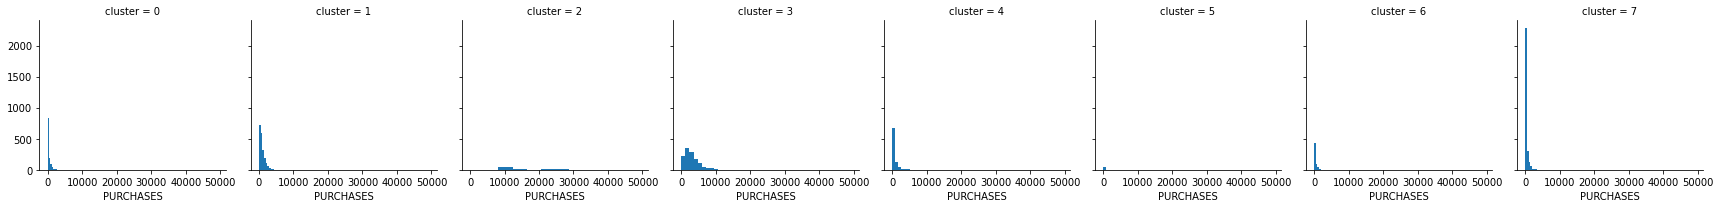

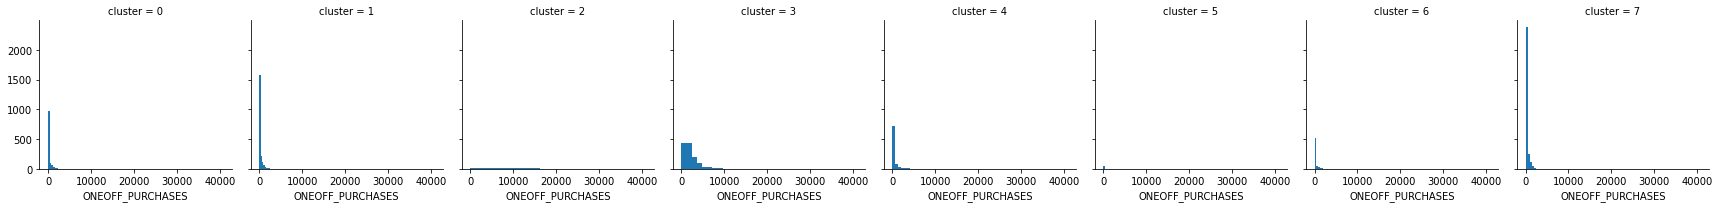

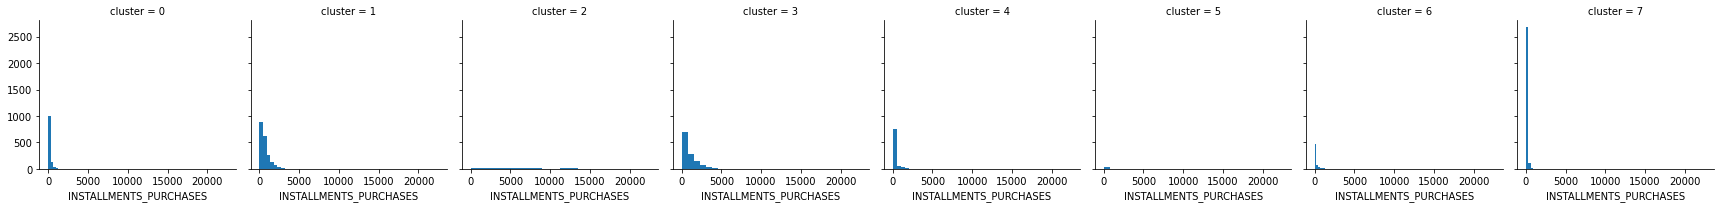

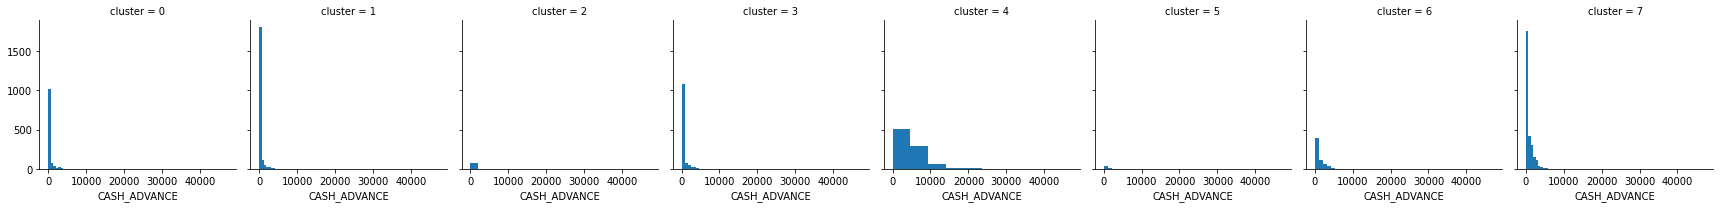

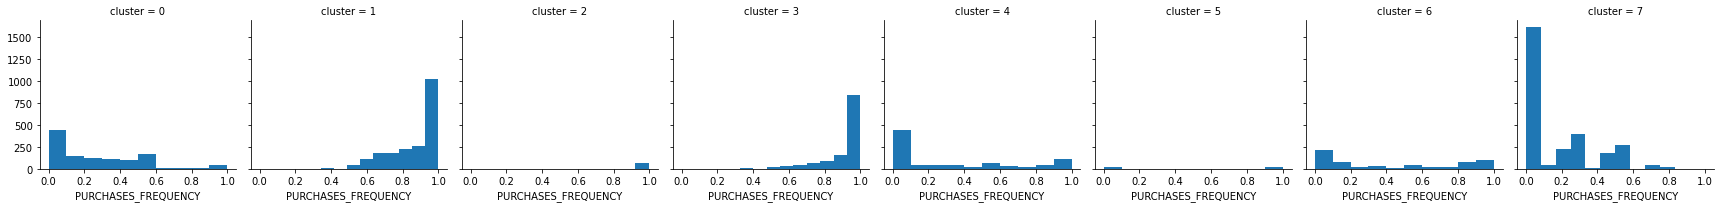

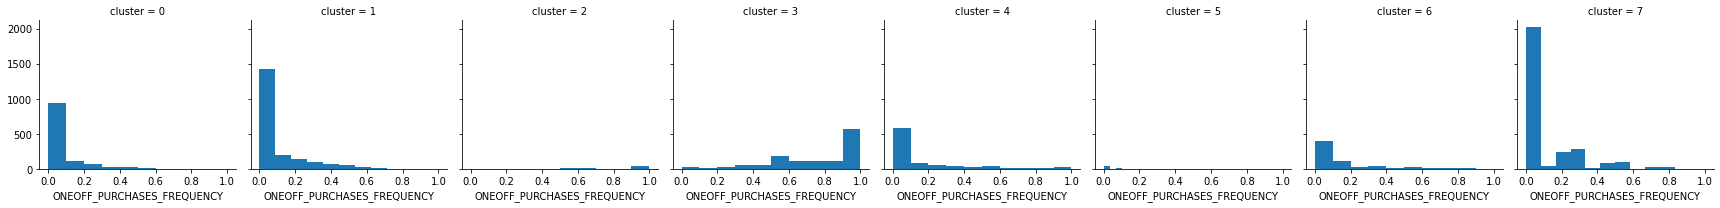

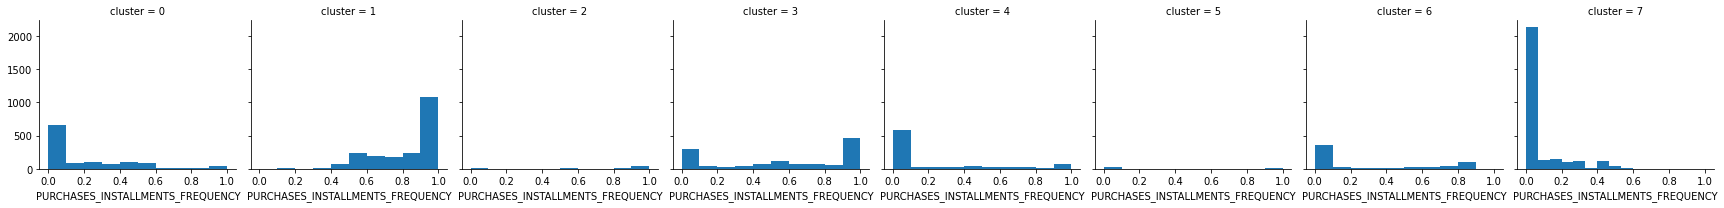

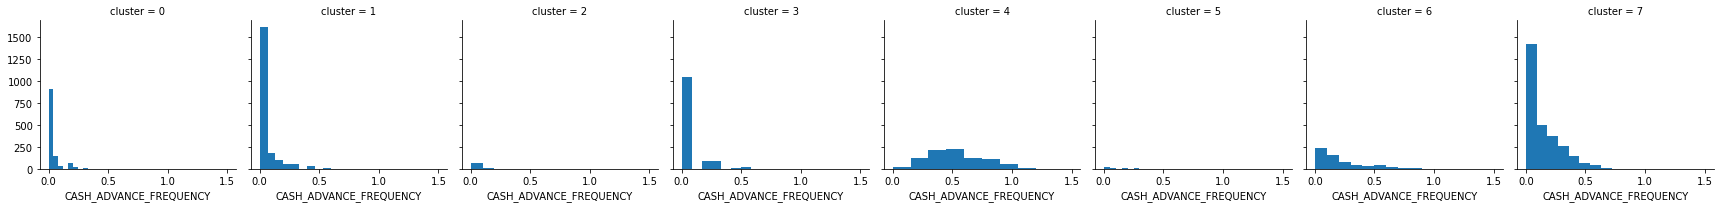

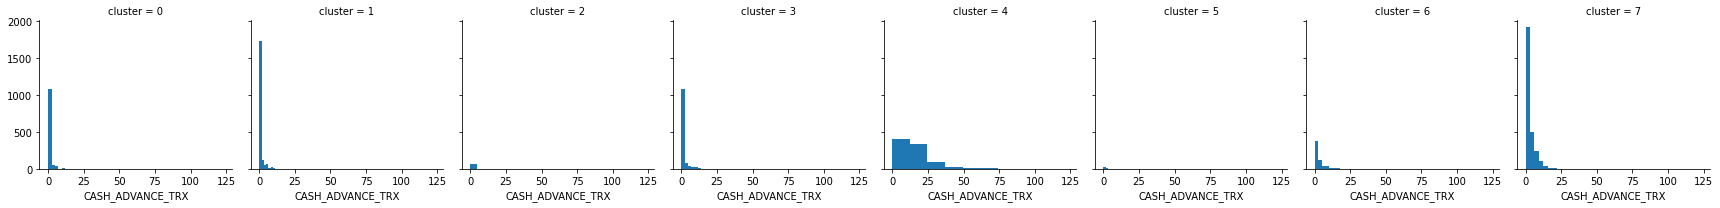

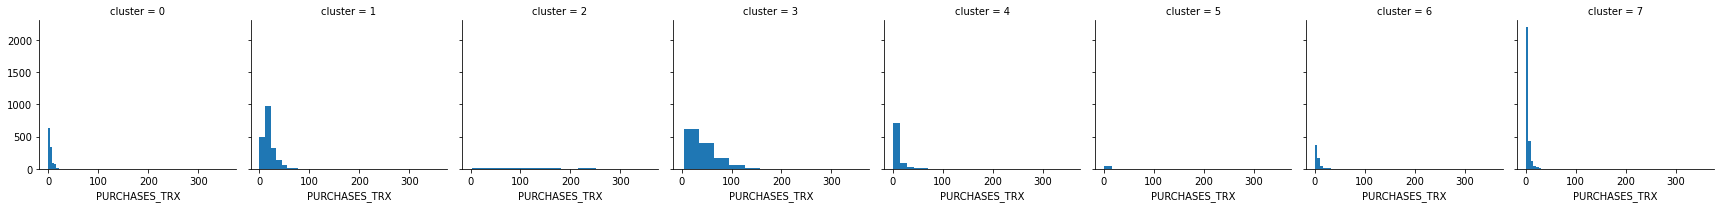

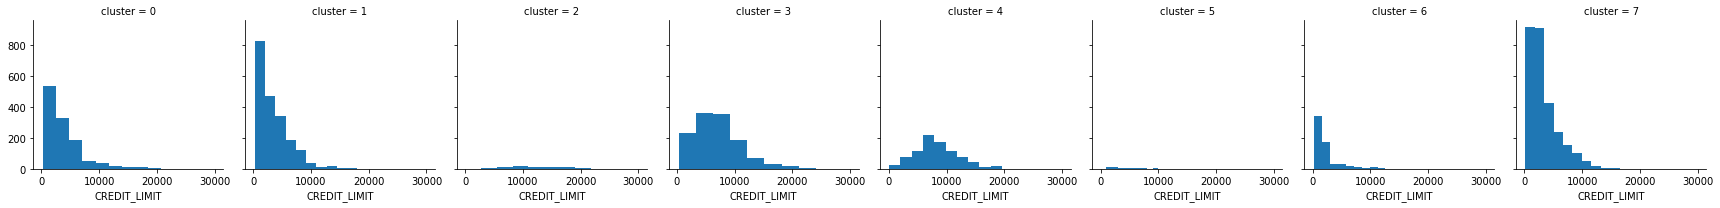

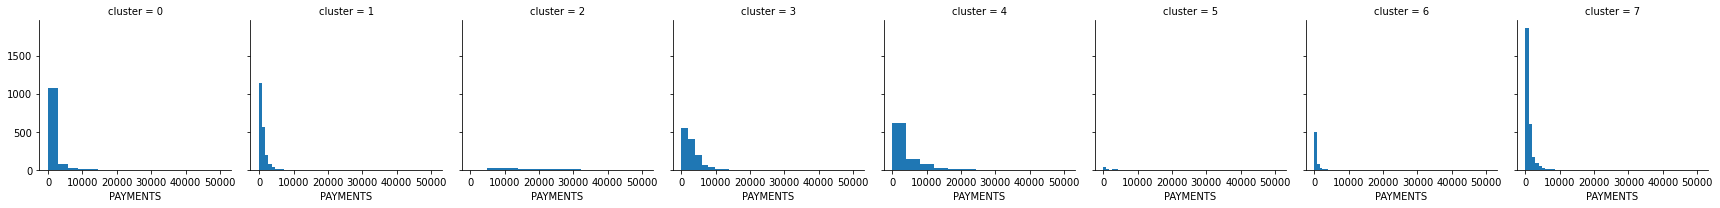

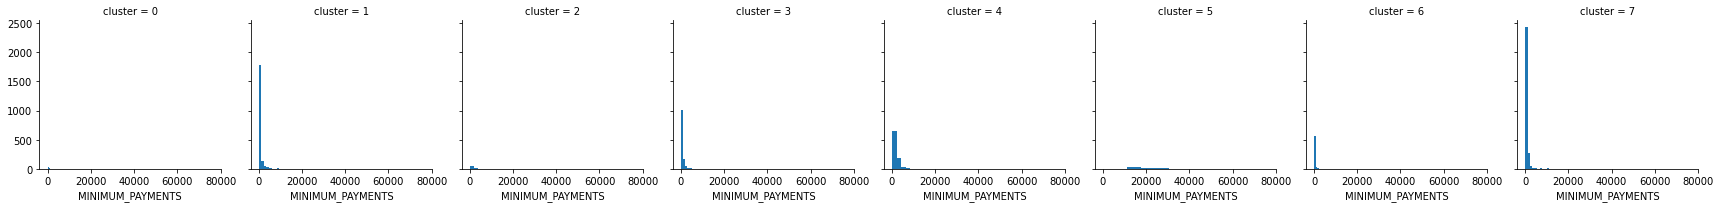

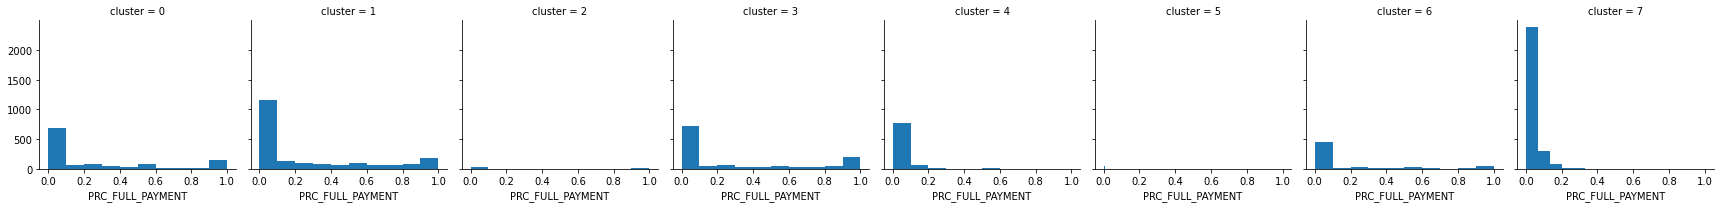

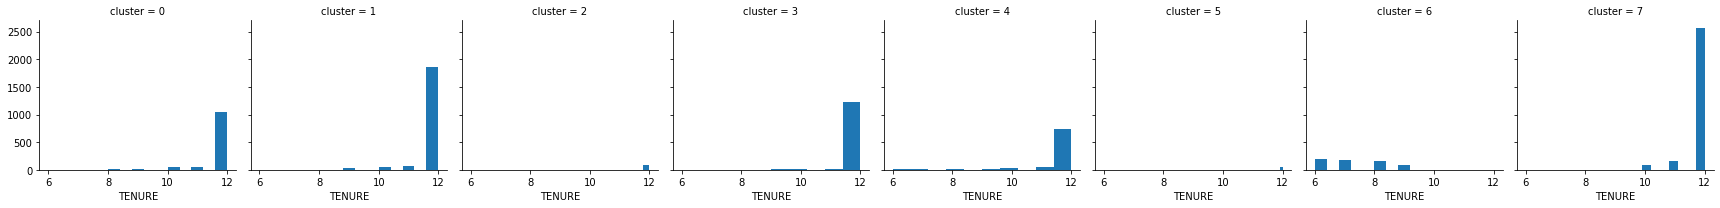

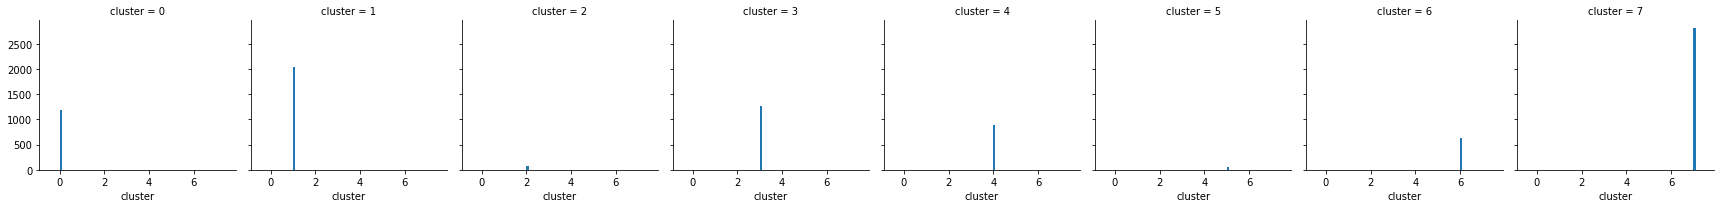

In [47]:
for col in X:
    grid = sns.FacetGrid(X, col='cluster')
    grid.map(plt.hist, col)

These are the seven clusters based on their char-act-ter-istics!


Bai.